In [1]:
import os
import torch
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms
from torchvision.transforms import Resize, Normalize
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [3]:
# Image transformations


# Initialize dataset
train_dataset = BirdDataset(csv_file='/kaggle/input/bdma-07-competition/BDMA7_project_files/train_metadata.csv',
                            img_dir='/kaggle/input/bdma-07-competition/BDMA7_project_files/train_images',
                            transform=transform)

NameError: name 'BirdDataset' is not defined

## Displaying Sample Images

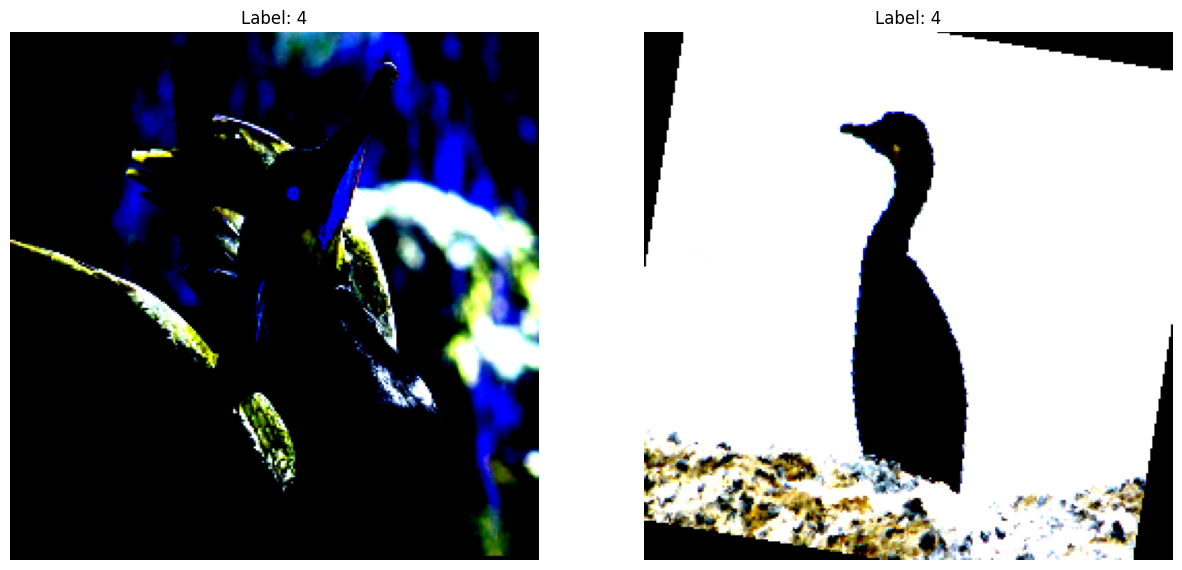

In [13]:
from torchvision import transforms
from torchvision.transforms import Resize, Normalize, ConvertImageDtype
import matplotlib.pyplot as plt

# Data Augmentation
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    #transforms.ToTensor(),
    ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_validation = transforms.Compose([
    transforms.Resize((256, 256)),
    #transforms.ToTensor(),
    ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class BirdDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)  # Ensures image is loaded correctly
    
        if image.shape[0] == 1:  # Check if the image is grayscale
            image = image.repeat(3, 1, 1)  # Convert to RGB by repeating the single channel
    
        label = self.img_labels.iloc[idx, 2]  # class_idx
        if self.transform:
            image = self.transform(image)
        return image, label
    

# Initialize dataset with the corrected transform
train_dataset = BirdDataset(csv_file='/kaggle/input/bdma-07-competition/BDMA7_project_files/train_metadata.csv',
                            img_dir='/kaggle/input/bdma-07-competition/BDMA7_project_files/train_images',
                            transform=transform_train)

def show_images(dataset, num_images=2):
    fig, ax = plt.subplots(1, num_images, figsize=(15, 7))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert CxHxW to HxWxC
        ax[i].imshow(image.numpy())
        ax[i].set_title(f'Label: {label}')
        ax[i].axis('off')
    plt.show()
show_images(train_dataset)


In [5]:
print(f"Length of training dataset: {len(train_dataset)}")

Length of training dataset: 1082
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [7]:
train_dataset[0]

(tensor([[[-1.3130, -1.4158, -1.5014,  ..., -1.2788, -1.2445, -1.2445],
          [-1.3987, -1.4843, -1.5528,  ..., -1.2617, -1.2274, -1.2274],
          [-1.4843, -1.5699, -1.6213,  ..., -1.2617, -1.2274, -1.1932],
          ...,
          [-1.7583, -1.7583, -1.8268,  ..., -1.2103, -1.2788, -1.2788],
          [-1.7412, -1.7240, -1.7754,  ..., -1.2788, -1.3302, -1.2788],
          [-1.7240, -1.6898, -1.6898,  ..., -1.3473, -1.4158, -1.3644]],
 
         [[-0.8452, -1.0553, -1.2129,  ..., -0.6877, -0.6001, -0.5476],
          [-0.9328, -1.1253, -1.2654,  ..., -0.7052, -0.6352, -0.5826],
          [-1.0203, -1.2129, -1.3179,  ..., -0.7402, -0.6877, -0.6527],
          ...,
          [-1.5980, -1.5980, -1.6681,  ..., -1.1954, -1.1604, -1.0903],
          [-1.5805, -1.5630, -1.6331,  ..., -1.2129, -1.1779, -1.1253],
          [-1.5630, -1.5280, -1.5455,  ..., -1.2129, -1.1779, -1.1429]],
 
         [[-0.4624, -0.6367, -0.7761,  ..., -0.2707, -0.1835, -0.1487],
          [-0.5670, -0.7064,

In [14]:
# Initialize dataset with the corrected transform
val_dataset = BirdDataset(csv_file='/kaggle/input/bdma-07-competition/BDMA7_project_files/val_metadata.csv',
                            img_dir='/kaggle/input/bdma-07-competition/BDMA7_project_files/val_images',
                            transform=transform_validation)

In [15]:
# Adjust the model architecture
class ModifiedCNN(nn.Module):
    def __init__(self, num_classes=20):
        super(ModifiedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 32 * 32, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256 * 32 * 32)
        x = self.classifier(x)
        return x


In [16]:
# Initialize the model
model = ModifiedCNN(num_classes=20).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Data Loader setup
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
import matplotlib.pyplot as plt

# Initialize metrics storage
epoch_losses = []
epoch_accuracies = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    
    # Validation phase
    model.eval()
    total_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    validation_accuracy = 100 * total_correct / total
    epoch_accuracies.append(validation_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')
    scheduler.step(avg_loss)

print("Training complete")

# 2. **Plotting the Metrics:**
# Plot training loss and validation accuracy
plt.figure(figsize=(12, 6))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(epoch_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


Epoch 1/100, Loss: 3.5333, Validation Accuracy: 3.88%
Epoch 2/100, Loss: 2.9960, Validation Accuracy: 3.88%
Epoch 3/100, Loss: 2.9960, Validation Accuracy: 3.88%
Epoch 4/100, Loss: 2.9960, Validation Accuracy: 3.88%
Epoch 5/100, Loss: 2.9959, Validation Accuracy: 3.88%
Epoch 6/100, Loss: 2.9957, Validation Accuracy: 2.91%
Epoch 7/100, Loss: 2.9957, Validation Accuracy: 2.91%
Epoch 8/100, Loss: 2.9957, Validation Accuracy: 2.91%
Epoch 9/100, Loss: 2.9958, Validation Accuracy: 2.91%
Epoch 10/100, Loss: 2.9957, Validation Accuracy: 2.91%
Epoch 11/100, Loss: 2.9957, Validation Accuracy: 2.91%
Epoch 12/100, Loss: 2.9956, Validation Accuracy: 2.91%
Epoch 13/100, Loss: 2.9954, Validation Accuracy: 2.91%
Epoch 14/100, Loss: 2.9957, Validation Accuracy: 1.94%
Epoch 15/100, Loss: 2.9955, Validation Accuracy: 1.94%
Epoch 16/100, Loss: 2.9953, Validation Accuracy: 2.91%
Epoch 17/100, Loss: 2.9955, Validation Accuracy: 1.94%
Epoch 18/100, Loss: 2.9953, Validation Accuracy: 1.94%
Epoch 19/100, Loss:

KeyboardInterrupt: 

In [17]:
# Training loop with modified learning rate scheduler
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validation phase
    model.eval()
    total_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    validation_accuracy = 100 * total_correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Validation Accuracy: {validation_accuracy:.2f}%')
    scheduler.step(total_loss/len(train_loader))

print("Training complete")

Epoch 1/100, Loss: 3.7883, Validation Accuracy: 6.80%
Epoch 2/100, Loss: 2.9964, Validation Accuracy: 1.94%
Epoch 3/100, Loss: 2.9961, Validation Accuracy: 1.94%
Epoch 4/100, Loss: 2.9961, Validation Accuracy: 1.94%
Epoch 5/100, Loss: 2.9961, Validation Accuracy: 1.94%


KeyboardInterrupt: 

## VGG Model

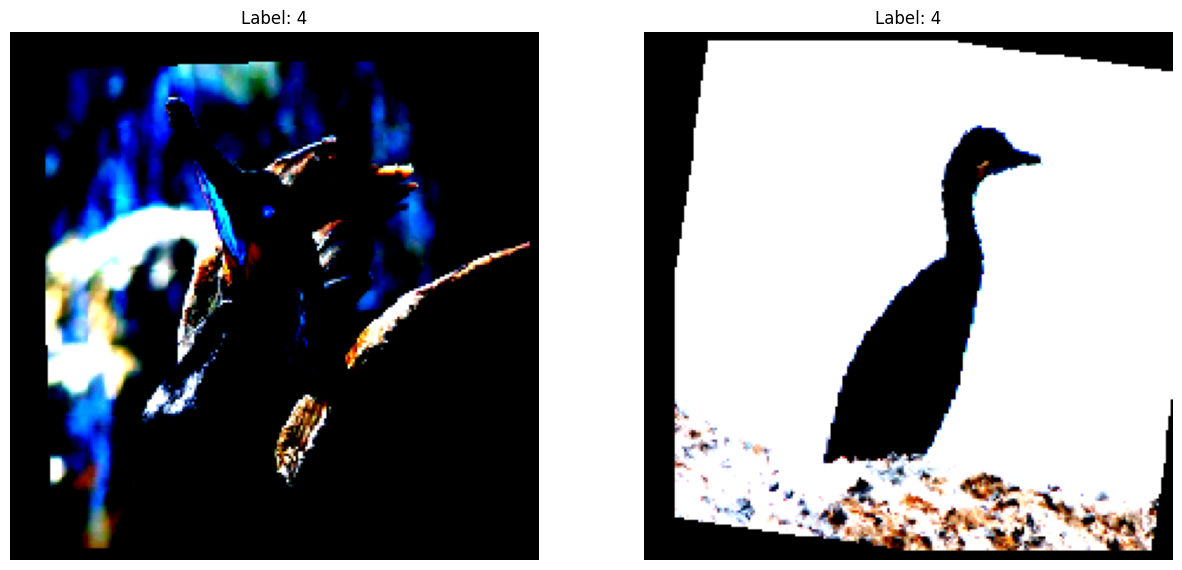

In [50]:
from torchvision import transforms
from torchvision.transforms import Resize, Normalize, ConvertImageDtype
import matplotlib.pyplot as plt

# Data Augmentation

transform_train_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=0.1, scale=(0.9, 1.1)),
    ConvertImageDtype(torch.float32),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


transform_validation_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    ConvertImageDtype(torch.float32),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class BirdDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)  # Ensures image is loaded correctly
    
        if image.shape[0] == 1:  # Check if the image is grayscale
            image = image.repeat(3, 1, 1)  # Convert to RGB by repeating the single channel
    
        label = self.img_labels.iloc[idx, 2]  # class_idx
        if self.transform:
            image = self.transform(image)
        return image, label
    

# Initialize dataset with the corrected transform
train_dataset = BirdDataset(csv_file='/kaggle/input/bdma-07-competition/BDMA7_project_files/train_metadata.csv',
                            img_dir='/kaggle/input/bdma-07-competition/BDMA7_project_files/train_images',
                            transform=transform_train_vgg)

def show_images(dataset, num_images=2):
    fig, ax = plt.subplots(1, num_images, figsize=(15, 7))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert CxHxW to HxWxC
        image.shape
        ax[i].imshow(image.numpy())
        ax[i].set_title(f'Label: {label}')
        ax[i].axis('off')
    plt.show()
show_images(train_dataset)


In [51]:
# Initialize dataset with the corrected transform
val_dataset = BirdDataset(csv_file='/kaggle/input/bdma-07-competition/BDMA7_project_files/val_metadata.csv',
                            img_dir='/kaggle/input/bdma-07-competition/BDMA7_project_files/val_images',
                            transform=transform_validation_vgg)

In [52]:
# Data Loader setup
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [53]:
import torch.nn as nn

# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False  # Freeze the parameters so we don't backprop through them

# Replace the classifier
vgg16.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512 * 7 * 7, 1950),  # Adjust the input features to match VGG16's output
    nn.ReLU(),
    nn.BatchNorm1d(1950),
    nn.Linear(1950, 200),  # Assuming 200 classes
    nn.Softmax(dim=1)
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
import torch.optim as optim

# Define the optimizer and loss function
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Define training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=100):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        model.eval()
        valid_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                accuracy += (predicted == labels).sum().item()
        
        valid_loss /= len(valid_loader)
        accuracy /= len(valid_loader.dataset)
        print(f'Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, Valid Loss: {valid_loss}, Accuracy: {accuracy}')
        
        # Early stopping logic could be added here

train_model(vgg16, train_loader, validation_loader, criterion, optimizer)



Epoch 1, Train Loss: 4.99265388881459, Valid Loss: 4.691550970077515, Accuracy: 0.5533980582524272
Epoch 2, Train Loss: 4.693155414917889, Valid Loss: 4.6134079694747925, Accuracy: 0.6213592233009708
Epoch 3, Train Loss: 4.611041040981517, Valid Loss: 4.549141526222229, Accuracy: 0.7378640776699029
Epoch 4, Train Loss: 4.559304461759679, Valid Loss: 4.50297749042511, Accuracy: 0.7669902912621359
Epoch 5, Train Loss: 4.521040902418249, Valid Loss: 4.539645075798035, Accuracy: 0.7378640776699029
Epoch 6, Train Loss: 4.508568076526418, Valid Loss: 4.513184666633606, Accuracy: 0.7572815533980582
Epoch 7, Train Loss: 4.4904197664821845, Valid Loss: 4.504849076271057, Accuracy: 0.7572815533980582
Epoch 8, Train Loss: 4.472863519892973, Valid Loss: 4.511828660964966, Accuracy: 0.7572815533980582
Epoch 9, Train Loss: 4.467205356149113, Valid Loss: 4.475976943969727, Accuracy: 0.8058252427184466
Epoch 10, Train Loss: 4.45036329942591, Valid Loss: 4.484391212463379, Accuracy: 0.7766990291262136


## InceptionV3 Model :

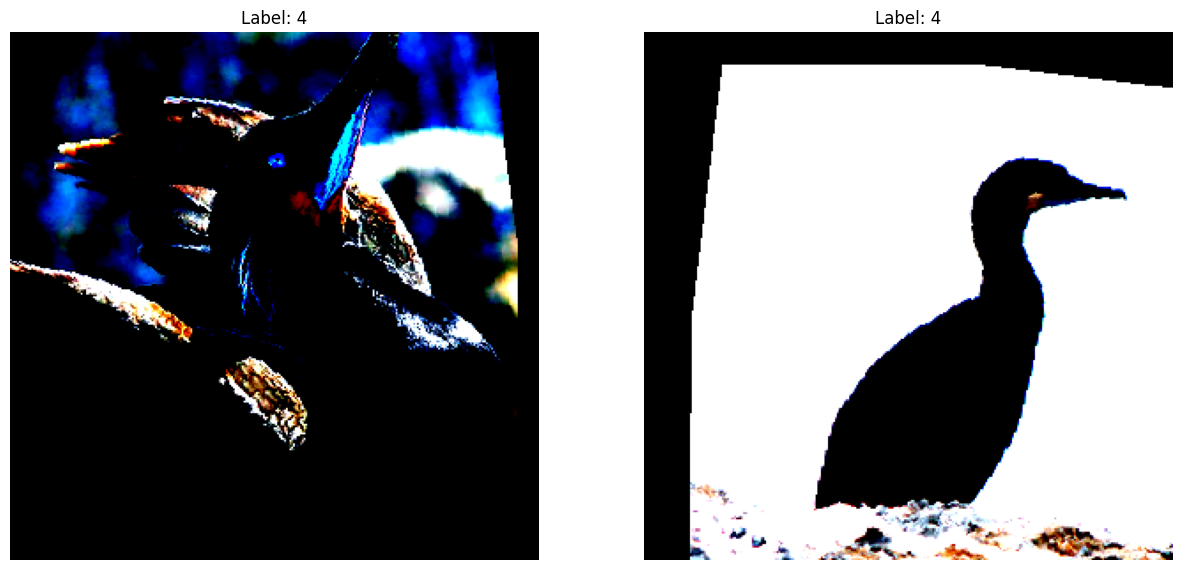

In [18]:
from torchvision import transforms
from torchvision.transforms import Resize, Normalize, ConvertImageDtype
import matplotlib.pyplot as plt

# Data Augmentation

transform_train_v3 = transforms.Compose([
    transforms.Resize(299),  # Resize so smaller edge is 299
    transforms.CenterCrop(299),  # Crop to 299x299
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=0.1, scale=(0.9, 1.1)),
    ConvertImageDtype(torch.float32),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


transform_validation_v3 = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    ConvertImageDtype(torch.float32),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class BirdDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)  # Ensures image is loaded correctly
    
        if image.shape[0] == 1:  # Check if the image is grayscale
            image = image.repeat(3, 1, 1)  # Convert to RGB by repeating the single channel
    
        label = self.img_labels.iloc[idx, 2]  # class_idx
        if self.transform:
            image = self.transform(image)
        return image, label
    

# Initialize dataset with the corrected transform
train_dataset = BirdDataset(csv_file='/kaggle/input/bdma-07-competition/BDMA7_project_files/train_metadata.csv',
                            img_dir='/kaggle/input/bdma-07-competition/BDMA7_project_files/train_images',
                            transform=transform_train_v3)

def show_images(dataset, num_images=2):
    fig, ax = plt.subplots(1, num_images, figsize=(15, 7))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert CxHxW to HxWxC
        image.shape
        ax[i].imshow(image.numpy())
        ax[i].set_title(f'Label: {label}')
        ax[i].axis('off')
    plt.show()
show_images(train_dataset)


In [19]:
# Initialize dataset with the corrected transform
val_dataset = BirdDataset(csv_file='/kaggle/input/bdma-07-competition/BDMA7_project_files/val_metadata.csv',
                            img_dir='/kaggle/input/bdma-07-competition/BDMA7_project_files/val_images',
                            transform=transform_validation_v3)

In [20]:
# Data Loader setup
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [32]:
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Initialize Inception V3 with pre-trained weights
inception = models.inception_v3(pretrained=True, aux_logits=True)
inception.aux_logits = False  # Disable auxiliary classifier if not needed

# Freeze all the layers
for param in inception.parameters():
    param.requires_grad = False

# Modify the primary classifier
inception.fc = nn.Linear(inception.fc.in_features, 20)  

# Move to the appropriate device
inception = inception.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [19]:
import torch.optim as optim


# Define the device at the beginning of your script
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the optimizer and loss function
optimizer = optim.Adam(inception.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Define training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=100):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        model.eval()
        valid_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                accuracy += (predicted == labels).sum().item()
        
        valid_loss /= len(valid_loader)
        accuracy /= len(valid_loader.dataset)
        print(f'Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, Valid Loss: {valid_loss}, Accuracy: {accuracy}')
        
        # Early stopping logic could be added here

train_model(inception, train_loader, validation_loader, criterion, optimizer)



Epoch 1, Train Loss: 2.705264449119568, Valid Loss: 2.2925426959991455, Accuracy: 0.5339805825242718
Epoch 2, Train Loss: 1.9708124995231628, Valid Loss: 1.7330973744392395, Accuracy: 0.5825242718446602
Epoch 3, Train Loss: 1.57861248885884, Valid Loss: 1.517589658498764, Accuracy: 0.6504854368932039
Epoch 4, Train Loss: 1.3177779685048496, Valid Loss: 1.2448953986167908, Accuracy: 0.6699029126213593
Epoch 5, Train Loss: 1.1561185945482815, Valid Loss: 1.2356459200382233, Accuracy: 0.7281553398058253
Epoch 6, Train Loss: 1.0377895604161655, Valid Loss: 1.0855983346700668, Accuracy: 0.7378640776699029
Epoch 7, Train Loss: 0.9768256176920498, Valid Loss: 0.9848557859659195, Accuracy: 0.7864077669902912
Epoch 8, Train Loss: 0.869841077748467, Valid Loss: 0.9467720538377762, Accuracy: 0.7572815533980582
Epoch 9, Train Loss: 0.8745959322242176, Valid Loss: 0.9447595775127411, Accuracy: 0.7475728155339806
Epoch 10, Train Loss: 0.7739072021316079, Valid Loss: 0.9214167594909668, Accuracy: 0.7

Epoch 1, Train Loss: 2.725310865570517, Valid Loss: 2.2069162130355835, Accuracy: 0.44660194174757284
Epoch 2, Train Loss: 1.9804770175148458, Valid Loss: 1.7256093323230743, Accuracy: 0.6213592233009708
Epoch 3, Train Loss: 1.585919769371257, Valid Loss: 1.4420826733112335, Accuracy: 0.7184466019417476
Epoch 4, Train Loss: 1.3253185153007507, Valid Loss: 1.273658573627472, Accuracy: 0.7087378640776699
Epoch 5, Train Loss: 1.1680448616252226, Valid Loss: 1.1024272590875626, Accuracy: 0.7378640776699029
Epoch 6, Train Loss: 1.0511989137705635, Valid Loss: 1.0363988280296326, Accuracy: 0.7669902912621359
Epoch 7, Train Loss: 0.9456150181153241, Valid Loss: 0.9749398678541183, Accuracy: 0.7669902912621359
Epoch 8, Train Loss: 0.8822077880887425, Valid Loss: 0.9403808861970901, Accuracy: 0.7864077669902912
Epoch 9, Train Loss: 0.8018065708525041, Valid Loss: 0.9002574384212494, Accuracy: 0.7961165048543689
Epoch 10, Train Loss: 0.804977651904611, Valid Loss: 0.9722604900598526, Accuracy: 0

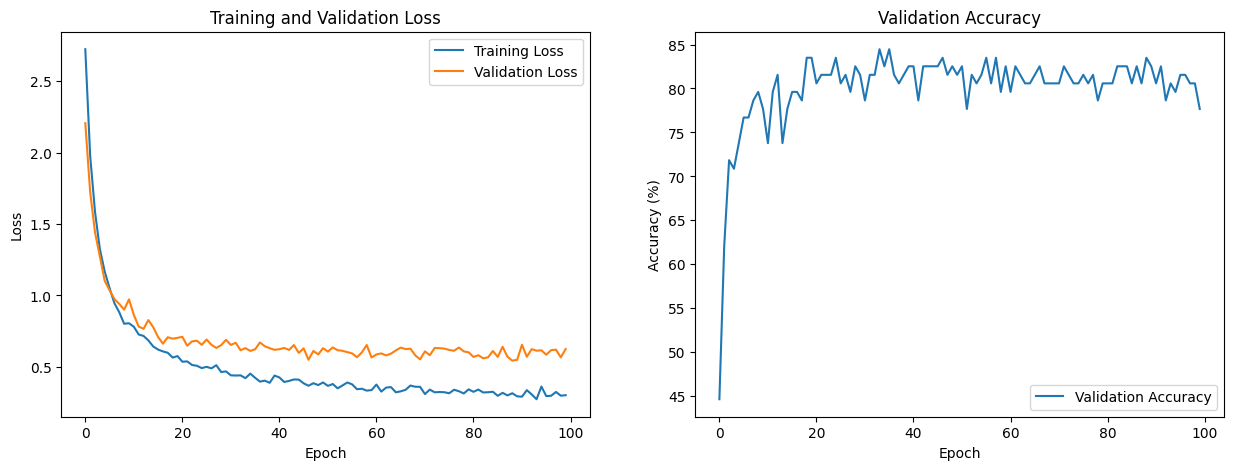

In [33]:
import torch.optim as optim


# Define the device at the beginning of your script
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the optimizer and loss function
optimizer = optim.Adam(inception.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Define training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=100):
    train_losses = []
    valid_losses = []
    accuracies = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        train_loss = running_loss/len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        valid_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                accuracy += (predicted == labels).sum().item()
        
        valid_loss /= len(valid_loader)
        accuracy /= len(valid_loader.dataset)
        valid_losses.append(valid_loss)
        accuracies.append(accuracy*100)
        print(f'Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, Valid Loss: {valid_loss}, Accuracy: {accuracy}')
        # Plotting the results
    plt.figure(figsize=(15, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()    
        
        # Early stopping logic could be added here

 

train_model(inception, train_loader, validation_loader, criterion, optimizer)



## Resnet 18:

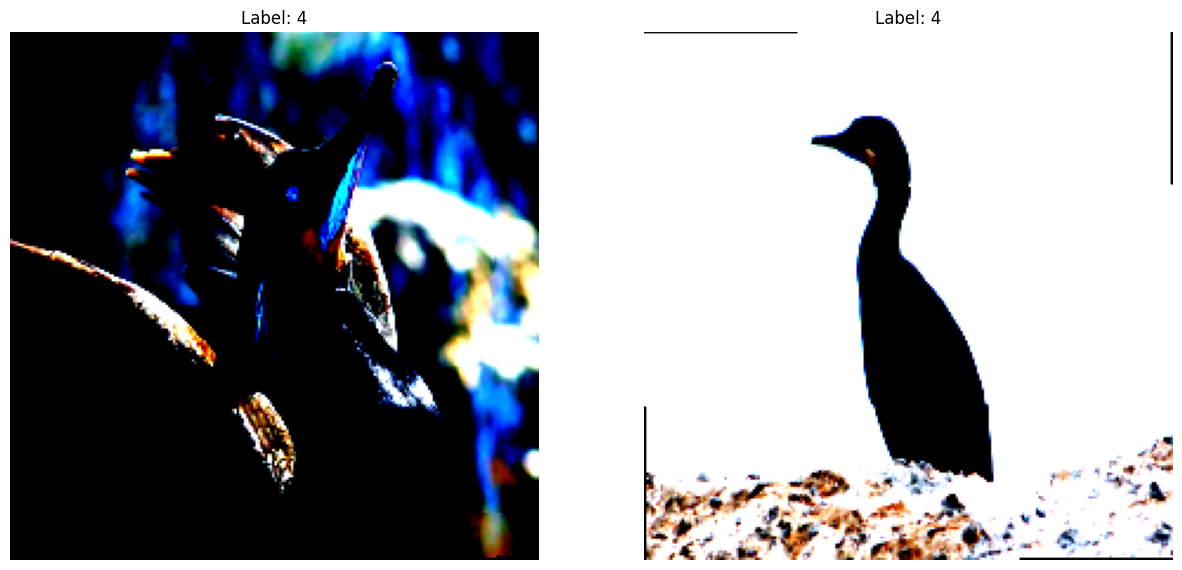

In [20]:
from torchvision import transforms
from torchvision.transforms import Resize, Normalize, ConvertImageDtype
import matplotlib.pyplot as plt

# Data Augmentation

transform_train_resnet18 = transforms.Compose([
    transforms.Resize((224, 224)),  # Match the input size of ResNet
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    ConvertImageDtype(torch.float32),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


transform_validation_resnet18 = transforms.Compose([
    transforms.Resize((224, 224)),
    ConvertImageDtype(torch.float32),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class BirdDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)  # Ensures image is loaded correctly
    
        if image.shape[0] == 1:  # Check if the image is grayscale
            image = image.repeat(3, 1, 1)  # Convert to RGB by repeating the single channel
    
        label = self.img_labels.iloc[idx, 2]  # class_idx
        if self.transform:
            image = self.transform(image)
        return image, label
    

# Initialize dataset with the corrected transform
train_dataset = BirdDataset(csv_file='/kaggle/input/bdma-07-competition/BDMA7_project_files/train_metadata.csv',
                            img_dir='/kaggle/input/bdma-07-competition/BDMA7_project_files/train_images',
                            transform=transform_train_resnet18)

def show_images(dataset, num_images=2):
    fig, ax = plt.subplots(1, num_images, figsize=(15, 7))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert CxHxW to HxWxC
        image.shape
        ax[i].imshow(image.numpy())
        ax[i].set_title(f'Label: {label}')
        ax[i].axis('off')
    plt.show()
show_images(train_dataset)


In [21]:
# Initialize dataset with the corrected transform
val_dataset = BirdDataset(csv_file='/kaggle/input/bdma-07-competition/BDMA7_project_files/val_metadata.csv',
                            img_dir='/kaggle/input/bdma-07-competition/BDMA7_project_files/val_images',
                            transform=transform_validation_resnet18)

In [22]:
# Data Loader setup
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [23]:
# Load a pretrained ResNet18 model
resnet18 = models.resnet18(pretrained=True)

# Freeze all the parameters in the feature extraction layers
for param in resnet18.parameters():
    param.requires_grad = False

# Replace the fully connected layer
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 200)  # Assuming 200 classes

# Move model to the appropriate device
resnet18.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.001)  # Only train the final layer

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


In [24]:
import torch.optim as optim


# Define the device at the beginning of your script
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=100):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        model.eval()
        valid_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                accuracy += (predicted == labels).sum().item()
        
        valid_loss /= len(valid_loader)
        accuracy /= len(valid_loader.dataset)
        print(f'Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, Valid Loss: {valid_loss}, Accuracy: {accuracy}')
        
        # Early stopping logic could be added here

train_model(resnet18, train_loader, validation_loader, criterion, optimizer)



Epoch 1, Train Loss: 3.0566225122002995, Valid Loss: 2.345115840435028, Accuracy: 0.2524271844660194
Epoch 2, Train Loss: 2.026964611866895, Valid Loss: 1.7000303268432617, Accuracy: 0.4368932038834951
Epoch 3, Train Loss: 1.5618345246595495, Valid Loss: 1.3335870504379272, Accuracy: 0.6699029126213593
Epoch 4, Train Loss: 1.234200977227267, Valid Loss: 1.140043467283249, Accuracy: 0.6504854368932039
Epoch 5, Train Loss: 1.0926367430125965, Valid Loss: 1.049352616071701, Accuracy: 0.6990291262135923
Epoch 6, Train Loss: 0.9482831779648276, Valid Loss: 1.0276107341051102, Accuracy: 0.6213592233009708
Epoch 7, Train Loss: 0.868781154646593, Valid Loss: 0.8842793852090836, Accuracy: 0.7378640776699029
Epoch 8, Train Loss: 0.7986951873582953, Valid Loss: 0.9531431049108505, Accuracy: 0.6504854368932039
Epoch 9, Train Loss: 0.7247618980267468, Valid Loss: 0.8688016682863235, Accuracy: 0.7475728155339806
Epoch 10, Train Loss: 0.7033059886273216, Valid Loss: 0.8166895359754562, Accuracy: 0.76

## Resnet 50:

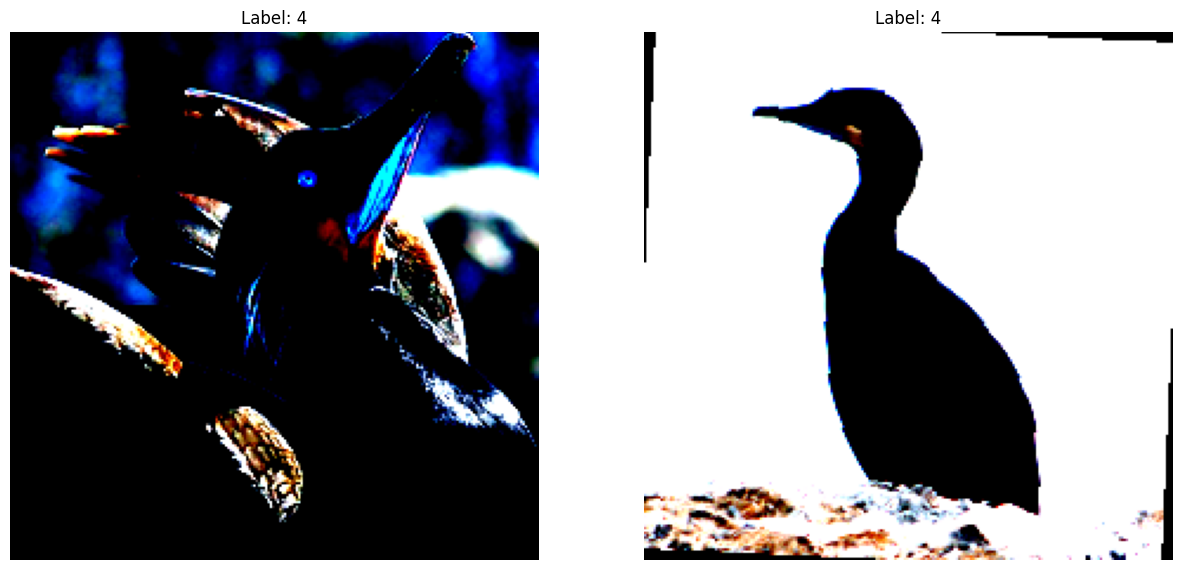

In [25]:
from torchvision import transforms
from torchvision.transforms import Resize, Normalize, ConvertImageDtype
import matplotlib.pyplot as plt

# Data Augmentation

transform_train_resnet50 = transforms.Compose([
    transforms.Resize(256),  # Slightly larger than required to allow for cropping
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    ConvertImageDtype(torch.float32),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


transform_validation_resnet50 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    ConvertImageDtype(torch.float32),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class BirdDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)  # Ensures image is loaded correctly
    
        if image.shape[0] == 1:  # Check if the image is grayscale
            image = image.repeat(3, 1, 1)  # Convert to RGB by repeating the single channel
    
        label = self.img_labels.iloc[idx, 2]  # class_idx
        if self.transform:
            image = self.transform(image)
        return image, label
    

# Initialize dataset with the corrected transform
train_dataset = BirdDataset(csv_file='/kaggle/input/bdma-07-competition/BDMA7_project_files/train_metadata.csv',
                            img_dir='/kaggle/input/bdma-07-competition/BDMA7_project_files/train_images',
                            transform=transform_train_resnet50)

def show_images(dataset, num_images=2):
    fig, ax = plt.subplots(1, num_images, figsize=(15, 7))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert CxHxW to HxWxC
        image.shape
        ax[i].imshow(image.numpy())
        ax[i].set_title(f'Label: {label}')
        ax[i].axis('off')
    plt.show()
show_images(train_dataset)


In [26]:
# Initialize dataset with the corrected transform
val_dataset = BirdDataset(csv_file='/kaggle/input/bdma-07-competition/BDMA7_project_files/val_metadata.csv',
                            img_dir='/kaggle/input/bdma-07-competition/BDMA7_project_files/val_images',
                            transform=transform_validation_resnet50)

In [27]:
# Data Loader setup
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [29]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pretrained ResNet50 model
resnet50 = models.resnet50(pretrained=True)

# Freeze all the parameters in the feature extraction layers
for param in resnet50.parameters():
    param.requires_grad = False

# Replace the fully connected layer to match the number of classes
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 20)  # Adjust for your number of classes

# Move model to the appropriate device
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
import torch.optim as optim


# Define the device at the beginning of your script
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=100):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        model.eval()
        valid_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                accuracy += (predicted == labels).sum().item()
        
        valid_loss /= len(valid_loader)
        accuracy /= len(valid_loader.dataset)
        print(f'Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, Valid Loss: {valid_loss}, Accuracy: {accuracy}')
        
        # Early stopping logic could be added here

train_model(resnet50, train_loader, validation_loader, criterion, optimizer)



Epoch 1, Train Loss: 3.034927894087399, Valid Loss: 3.0480637550354004, Accuracy: 0.038834951456310676
Epoch 2, Train Loss: 3.038666009902954, Valid Loss: 3.0503286719322205, Accuracy: 0.04854368932038835
Epoch 3, Train Loss: 3.034229131305919, Valid Loss: 3.044959306716919, Accuracy: 0.038834951456310676
Epoch 4, Train Loss: 3.039334577672622, Valid Loss: 3.0466490983963013, Accuracy: 0.05825242718446602
Epoch 5, Train Loss: 3.035908439580132, Valid Loss: 3.0502188205718994, Accuracy: 0.04854368932038835
Epoch 6, Train Loss: 3.034812969319961, Valid Loss: 3.0466918349266052, Accuracy: 0.05825242718446602
Epoch 7, Train Loss: 3.032978233169107, Valid Loss: 3.0480790734291077, Accuracy: 0.038834951456310676
Epoch 8, Train Loss: 3.03538874317618, Valid Loss: 3.048148453235626, Accuracy: 0.038834951456310676
Epoch 9, Train Loss: 3.0299268329844757, Valid Loss: 3.0469585061073303, Accuracy: 0.04854368932038835
Epoch 10, Train Loss: 3.032056822496302, Valid Loss: 3.048245131969452, Accuracy

## Vae Approach

In [4]:
import numpy as npAE
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import os
#from torch.optim import Adam
from tqdm.notebook import tqdm
import math
import random
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

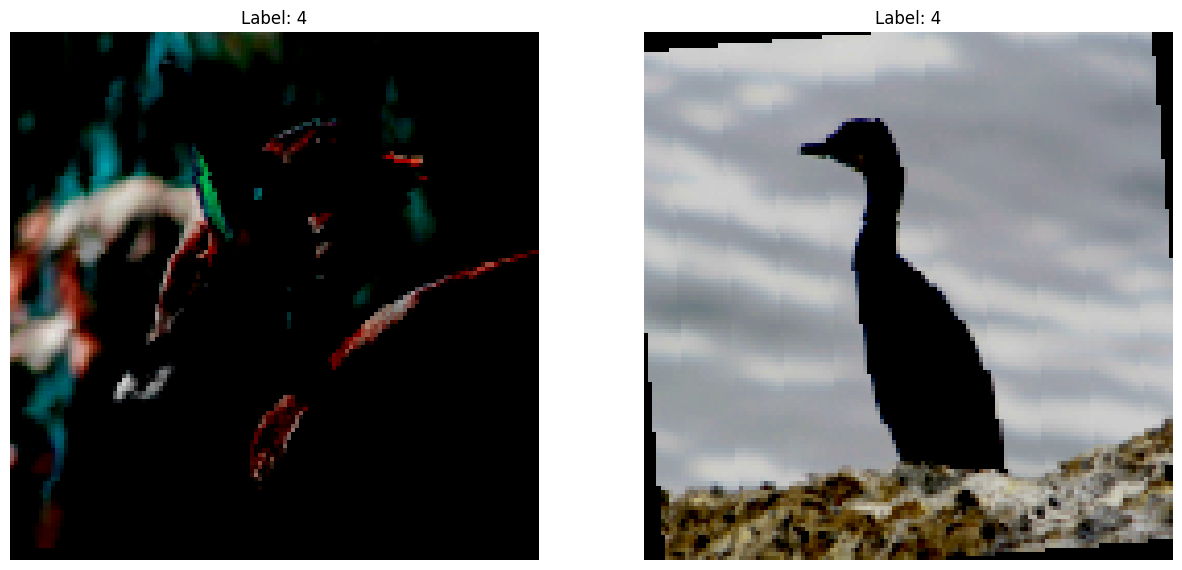

In [5]:
from torchvision import transforms
from torchvision.transforms import Resize, Normalize, ConvertImageDtype
import matplotlib.pyplot as plt

# Data Augmentation
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    #transforms.ToTensor(),
    ConvertImageDtype(torch.float32),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_validation = transforms.Compose([
    transforms.Resize((128, 128)),
    #transforms.ToTensor(),
    ConvertImageDtype(torch.float32),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class BirdDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)  # Ensures image is loaded correctly
    
        if image.shape[0] == 1:  # Check if the image is grayscale
            image = image.repeat(3, 1, 1)  # Convert to RGB by repeating the single channel
    
        label = self.img_labels.iloc[idx, 2]  # class_idx
        if self.transform:
            image = self.transform(image)
        return image, label
    

# Initialize dataset with the corrected transform
train_dataset = BirdDataset(csv_file='/kaggle/input/bdma-07-competition/BDMA7_project_files/train_metadata.csv',
                            img_dir='/kaggle/input/bdma-07-competition/BDMA7_project_files/train_images',
                            transform=transform_train)

def show_images(dataset, num_images=2):
    fig, ax = plt.subplots(1, num_images, figsize=(15, 7))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert CxHxW to HxWxC
        ax[i].imshow(image.numpy())
        ax[i].set_title(f'Label: {label}')
        ax[i].axis('off')
    plt.show()
show_images(train_dataset)


In [6]:
# Initialize dataset with the corrected transform
val_dataset = BirdDataset(csv_file='/kaggle/input/bdma-07-competition/BDMA7_project_files/val_metadata.csv',
                            img_dir='/kaggle/input/bdma-07-competition/BDMA7_project_files/val_images',
                            transform=transform_validation)

In [7]:
# Data Loader setup
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
class VAE_with_conv(nn.Module):
    def __init__(self, latent_dim=128, device=device):
        super(VAE_with_conv, self).__init__()
        self.latent_dim = latent_dim
        hidden_dims = [32, 64, 128, 256, 512]  # Define the sizes of hidden layers
        
        # Encoder
        modules = []
        input_channels = 3  # Start with RGB images
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(input_channels, h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            input_channels = h_dim  # Update input_channels to the output of the current layer

        self.encoder = nn.Sequential(*modules)
        self.flatten_size = 512 * 4 * 4  
        # Latent mean and variance
        self.mean_layer = nn.Linear(self.flatten_size, latent_dim)
        self.logvar_layer = nn.Linear(self.flatten_size, latent_dim)
        
        # Decoder
        hidden_dims.reverse()
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[0] * 4 * 4) # j'ai change ia a 0
        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i + 1],
                                       kernel_size=3, stride=2,
                                       padding=1, output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
        self.decoder = nn.Sequential(*modules)
        #self.final_adjustment = nn.AdaptiveAvgPool2d((112, 112))
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1], 3,
                               kernel_size=3,
                               padding=1),  # Last layer might need adjustment
            nn.Tanh())

     
    def encode(self, x):
        x = self.encoder(x)
        #print("Output size before flattening:", x.size())
        x = torch.flatten(x, start_dim=1)
        #print("Output size after flattening:", x.size())
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        x = self.decoder_input(x)
        x = x.view(-1, 512, 4, 4)  # Adjust the shape to match the input expected by the decoder
        x = self.decoder(x)
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)  
        x = self.final_layer(x)
        return x

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar


In [10]:
# Assuming the class VAE_with_conv and necessary imports are already defined
vae_model = VAE_with_conv(latent_dim=128, device=device)
vae_model.load_state_dict(torch.load('/kaggle/input/vae-model-2/pytorch/default/1/vae_model.pt', map_location=device))
vae_model.eval()


<ipython-input-10-37cd73e0fd68>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load('/kaggle/input/vae-model-2/pytorch/default/1/vae_model.

VAE_with_conv(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4):

In [11]:
class VAE_Classifier(nn.Module):
    def __init__(self, vae_model, output_features):
        super(VAE_Classifier, self).__init__()
        self.encoder = vae_model.encoder
        self.flatten_size = vae_model.flatten_size
        self.classifier = nn.Sequential(
            nn.Linear(vae_model.flatten_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, output_features)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, self.flatten_size)
        x = self.classifier(x)
        return x


In [12]:
n_classes = 20  # Modify as per your dataset
classifier_model = VAE_Classifier(vae_model, n_classes).to(device)


Epoch 1: Train Loss: 3.2354, Valid Loss: 2.8257, Train Acc: 8.13%, Valid Acc: 11.65%
Epoch 2: Train Loss: 2.8351, Valid Loss: 2.5433, Train Acc: 11.74%, Valid Acc: 13.59%
Epoch 3: Train Loss: 2.7439, Valid Loss: 2.6337, Train Acc: 10.91%, Valid Acc: 9.71%
Epoch 4: Train Loss: 2.6627, Valid Loss: 2.6166, Train Acc: 14.42%, Valid Acc: 9.71%
Epoch 5: Train Loss: 2.6140, Valid Loss: 2.5124, Train Acc: 15.34%, Valid Acc: 18.45%
Epoch 6: Train Loss: 2.5755, Valid Loss: 2.6776, Train Acc: 15.99%, Valid Acc: 16.50%
Epoch 7: Train Loss: 2.5425, Valid Loss: 2.5657, Train Acc: 16.91%, Valid Acc: 12.62%
Epoch 8: Train Loss: 2.5388, Valid Loss: 2.3405, Train Acc: 17.28%, Valid Acc: 18.45%
Epoch 9: Train Loss: 2.4754, Valid Loss: 2.3582, Train Acc: 19.04%, Valid Acc: 20.39%
Epoch 10: Train Loss: 2.4644, Valid Loss: 2.4136, Train Acc: 19.04%, Valid Acc: 21.36%
Epoch 11: Train Loss: 2.4437, Valid Loss: 2.3478, Train Acc: 19.22%, Valid Acc: 21.36%
Epoch 12: Train Loss: 2.3575, Valid Loss: 2.2031, Train

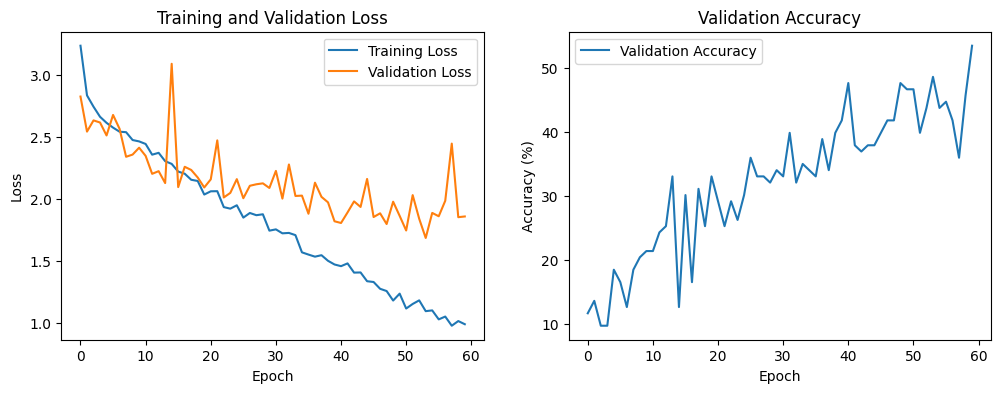

In [13]:
import matplotlib.pyplot as plt

def train_classifier(model, train_loader, valid_loader, criterion, optimizer, epochs=60):
    # Lists to store metrics for plotting
    train_losses = []
    valid_losses = []
    accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy
        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        valid_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        valid_loss /= len(valid_loader)
        valid_accuracy = 100 * correct / total
        valid_losses.append(valid_loss)
        accuracies.append(valid_accuracy)

        # Print epoch results
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Acc: {valid_accuracy:.2f}%')

    # Plotting the training loss, validation loss and accuracy
    plt.figure(figsize=(12, 4))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

# Set up the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier_model.parameters(), lr=0.001)

# Train the model
train_classifier(classifier_model, train_loader, validation_loader, criterion, optimizer)


Epoch 1: Train Loss: 1.2186, Valid Loss: 2.0794, Train Acc: 59.33%, Valid Acc: 35.92%
Epoch 2: Train Loss: 1.0468, Valid Loss: 2.1942, Train Acc: 63.59%, Valid Acc: 36.89%
Epoch 3: Train Loss: 1.0710, Valid Loss: 2.4821, Train Acc: 64.60%, Valid Acc: 33.01%
Epoch 4: Train Loss: 0.9974, Valid Loss: 2.0907, Train Acc: 65.62%, Valid Acc: 40.78%
Epoch 5: Train Loss: 0.9777, Valid Loss: 2.1723, Train Acc: 66.36%, Valid Acc: 35.92%
Epoch 6: Train Loss: 0.9025, Valid Loss: 2.2473, Train Acc: 67.74%, Valid Acc: 34.95%
Epoch 7: Train Loss: 0.8893, Valid Loss: 2.5459, Train Acc: 69.04%, Valid Acc: 36.89%
Epoch 8: Train Loss: 0.9256, Valid Loss: 2.5097, Train Acc: 67.93%, Valid Acc: 34.95%
Epoch 9: Train Loss: 0.8139, Valid Loss: 2.3409, Train Acc: 72.00%, Valid Acc: 37.86%
Epoch 10: Train Loss: 0.7746, Valid Loss: 2.3989, Train Acc: 72.00%, Valid Acc: 37.86%
Epoch 11: Train Loss: 0.8010, Valid Loss: 2.2645, Train Acc: 71.26%, Valid Acc: 39.81%
Epoch 12: Train Loss: 0.7071, Valid Loss: 2.7069, Tr

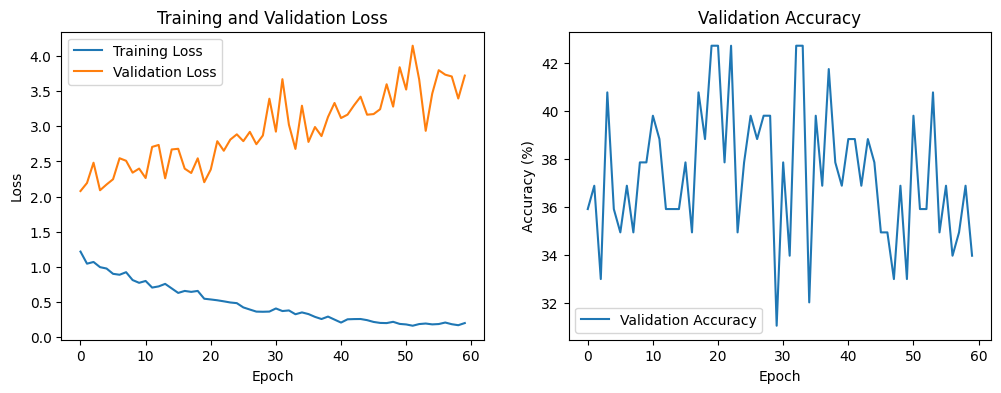

In [22]:
import matplotlib.pyplot as plt

def train_classifier(model, train_loader, valid_loader, criterion, optimizer, epochs=60):
    # Lists to store metrics for plotting
    train_losses = []
    valid_losses = []
    accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy
        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        valid_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        valid_loss /= len(valid_loader)
        valid_accuracy = 100 * correct / total
        valid_losses.append(valid_loss)
        accuracies.append(valid_accuracy)

        # Print epoch results
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Acc: {valid_accuracy:.2f}%')

    # Plotting the training loss, validation loss and accuracy
    plt.figure(figsize=(12, 4))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

# Set up the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier_model.parameters(), lr=0.001)

# Train the model
train_classifier(classifier_model, train_loader, validation_loader, criterion, optimizer)
